# Planejamento da solução

-- Objetivo do problema: Previsão do primeiro destino que um novo usuário irá escolher

- Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )
            
           Gross Revenue = ( Fee*Numero cliente ) - CAC 

#
-- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**
        
--- Esperado 16 ciclos

# 0.0 Imports

In [3]:
import random
import pickle
import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt
from pycorrcat  import pycorrcat

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as me
from scikitplot import metrics      as mt

from keras      import models as ml
from keras      import layers as la

## 0.1 Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()
    

## 0.2 Load Data

In [5]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv', low_memory=False)
df_sessions = pd.read_csv('../data/raw/sessions.csv', low_memory=False)

# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1 Data Dimension

In [7]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 213451
number of cols: 16


In [8]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of cols: {df_sessions.shape[1]}')

number of rows: 10567737
number of cols: 6


## 1.2 Data Types

In [9]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [10]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [11]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4 Replace NA

In [13]:
# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].astype('int64').mean()
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3% 
# # action - 0.7% 
# # action_type - 11% 
# # action_detail - 11% 
# # secs_elapsed - 1.2%
df_sessions = df_sessions.dropna()

In [14]:
df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [15]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5 Change Types

In [16]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

In [17]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6 Check Balanced Data

In [18]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.7 Descriptive Statistical

In [19]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop('user_id', axis=1)
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1 Numerical Attributes - Users

In [20]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
age,16.0,115.0,99.0,37.405591,34.0,13.939900,2.089718,6.516468
signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604723,2.705871,5.928298


### 1.7.2 Numerical Attributes - Sessions

In [21]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes_sessions.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.39327,11.137761,154.84312


### 1.7.3 Categorical Attributes - Users

In [22]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.7.4 Categorical Attributes - Sessions

In [23]:
cat_attributes_sessions.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


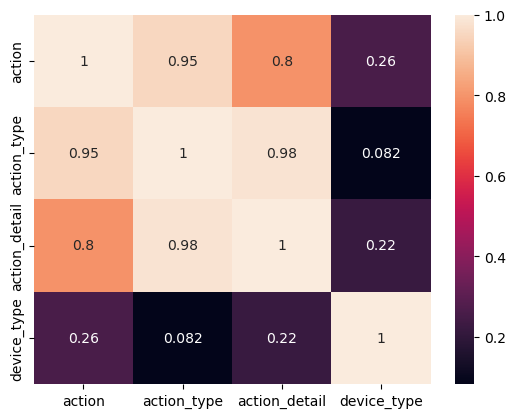

In [25]:
# Cramer V correlation
d = pycorrcat.corr_matrix(cat_attributes_sessions, ['action', 'action_type', 'action_detail', 'device_type'])
sns.heatmap(d, annot=True);

# 2.0 Data Filtering

In [26]:
df2 = df1.copy()

## 2.1. Filtering Rows

In [29]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df2 = df2[( df2['age'] > 15 ) & ( df2['age'] < 120 )]

## 2.2. Columns Selection

# 3.0 Feature Engineering

In [30]:
df3 = df2.copy()

In [31]:
 # days from first active up to first booking
df3['first_active'] = pd.to_datetime(df3['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df3['days_from_frist_active_until_booking'] = (df3['date_first_booking'] - df3['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df3['days_from_first_active_until_account_created'] = (df3['date_account_created'] - df3['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df3['days_from_account_created_until_first_booking'] = (df3['date_first_booking'] - df3['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df3['year_first_active'] = df3['first_active'].dt.year

# month first active
df3['month_fist_active'] = df3['first_active'].dt.month

# day first active
df3['day_first_active'] = df3['first_active'].dt.day

# day of week first active
df3['day_of_week_first_active'] = df3['first_active'].dt.dayofweek

# week of year first active
df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df3['year_first_booking'] = df3['date_first_booking'].dt.year

# month first booking
df3['month_first_booking'] = df3['date_first_booking'].dt.month

# day first booking
df3['day_first_booking'] = df3['date_first_booking'].dt.day

# day of week first booking
df3['day_of_week_first_booking'] = df3['date_first_booking'].dt.dayofweek

# week of year first booking
df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df3['year_account_created'] = df3['date_account_created'].dt.year

# month  account_created
df3['month_account_created'] = df3['date_account_created'].dt.month

# day  account_created
df3['day_account_created'] = df3['date_account_created'].dt.day

# day of week  account_created
df3['day_of_week_account_created'] = df3['date_account_created'].dt.dayofweek

# week of year  account_created
df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear

C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_980\1886894544.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_980\1886894544.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_980\1886894544.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear


In [32]:
df3.isna().sum()

id                                               0
date_account_created                             0
timestamp_first_active                           0
date_first_booking                               0
gender                                           0
age                                              0
signup_method                                    0
signup_flow                                      0
language                                         0
affiliate_channel                                0
affiliate_provider                               0
first_affiliate_tracked                          0
signup_app                                       0
first_device_type                                0
first_browser                                    0
country_destination                              0
first_active                                     0
days_from_frist_active_until_booking             0
days_from_first_active_until_account_created     0
days_from_account_created_until

In [33]:
df3.shape

(122636, 35)

# 4.0 Exploratory Data Analysis

# 5.0 Data Preparation

In [34]:
df5 = df3.copy()

In [35]:
# dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1 ))

# join id
df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1)

In [36]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

In [52]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#  # dummy variable
# X_test_dummy = pd.get_dummies(X_test.drop( ['id'], axis=1))

# # join id and
# X_test = pd.concat([X_test[['id']], X_test_dummy], axis=1)

# 6.0 Feature Selection

In [53]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates

df6_train = X_train.drop(cols_drop, axis=1)

In [54]:
df6_test = X_test.drop(cols_drop, axis=1)

In [ ]:
# # Saving Interim Data
# df6_train.to_parquet('../data/interim/df6_train.parquet')
# df6_test.to_parquet('../data/interim/df6_test.parquet')

# pickle.dump(y_train, open('../data/interim/y_train.pkl', 'wb'))
# pickle.dump(y_test, open('../data/interim/y_test.pkl', 'wb'))

# 7.0 Machine Learning Modelling

In [55]:
x_train = df6_train.drop('id', axis=1)
x_test = df6_test.drop('id', axis=1)

## 7.1 Baseline Model

In [56]:
cd_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
cd_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=cd_list, weights=cd_weights, k=k_num)

### 7.1.1 Baseline Model Performance

Accuracy: 0.3593036529680365
Accuracy: 0.0823439760811336
Accuracy: -0.001131572172633044
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        86
          CA       0.01      0.00      0.01       213
          DE       0.00      0.00      0.00       168
          ES       0.02      0.02      0.02       337
          FR       0.02      0.02      0.02       734
          GB       0.01      0.01      0.01       352
          IT       0.01      0.01      0.01       403
         NDF       0.45      0.45      0.45     10971
          NL       0.01      0.01      0.01       119
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9612
       other       0.07      0.07      0.07      1502

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



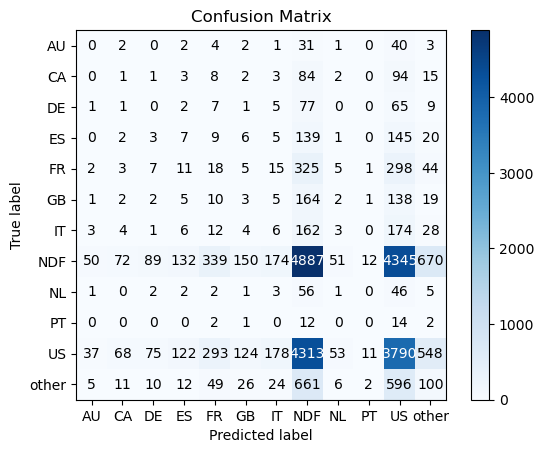

In [57]:
# Accuracy
acc_random = me.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = me.balanced_accuracy_score(y_test, yhat_random)
print(f'Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = me.cohen_kappa_score(y_test, yhat_random)
print(f'Accuracy: {kappa_random}')

# Classification report
print(me.classification_report( y_test, yhat_random ))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False);

## 7.1 Neural Network MLP

In [58]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [59]:
# model definition
model = ml.Sequential()
model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(la.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=50, verbose=False)

### 7.1.1 NN Performance

767/767 [==============================] - 1s 2ms/step
Accuracy: 0.8388372472276582
Balanced Accuracy: 0.1665973089194063
Kappa Score: 0.7237119306757309


f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        86
          CA       0.00      0.00      0.00       213
          DE       0.00      0.00      0.00       168
          ES       0.00      0.00      0.00       337
          FR       0.00      0.00      0.00       734
          GB       0.00      0.00      0.00       352
          IT       0.00      0.00      0.00       403
         NDF       1.00      1.00      1.00     10971
          NL       0.00      0.00      0.00       119
          PT       0.00      0.00      0.00        31
          US       0.71      1.00      0.83      9612
       other       0.00      0.00      0.00      1502

    accuracy                           0.84     24528
   macro avg       0.14      0.17      0.15     24528
weighted avg       0.72      0.84      0.77     24528



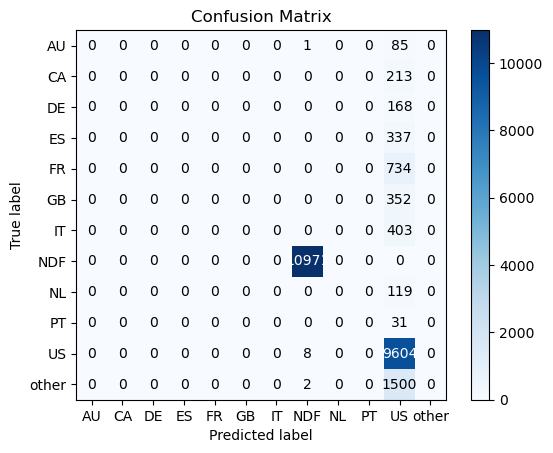

In [60]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]


# -------------------------- Metrics --------------------------
# Accuracy
acc_nn = me.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = me.balanced_accuracy_score(y_test, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = me.cohen_kappa_score(y_test, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(me.classification_report(y_test, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False);

### 7.1.2 NN Performance - Cross-Validation

In [ ]:
# # generate k-fold
# num_folds = 5
# kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# balanced_acc_list = []
# kappa_acc_list = []

# i = 1
# for train_ix, val_ix in kfold.split(x_train, y_train):
#     print(f'Fold Number: {i}/{num_folds}')
    
#     # get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]
    
#     # target hot-encoding
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
#     model.add(la.Dense(12, activation='softmax'))

#     # compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # training model
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

#     # prediction
#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
    
#     # prepare data
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1, -1)[0]

#     # metrics
#     ## Balanced Accuracy 
#     balanced_acc_nn = me.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
    
#     ## Kappa Metrics
#     kappa_acc_nn = me.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_acc_list.append(kappa_acc_nn)
    
#     i += 1

In [ ]:
# print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}')
# print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')